## Rapport : Résolution de Problèmes / Machine Learning

#### IMT Mines Alès Octobre 2022
##### INFRES 13 
- **Quentin BIALOTA**
- **Alexandre BOMPUIS**
- **Julia LOCATELLI**
- **Tom L'HERMENIER**

![Logo IMT](https://www.fondation-mines-telecom.org/wp-content/uploads/2018/02/imt_mines_ales-300x158.jpg)

---

Dans le cadre de du cours de **ANN & Deep learning** à l'IMT Mines Alès, nous avons réalisé un projet de notre choix, visant à résoudre un problème de machine learning, le tout en évaluant et comparant quelques modèles pour la résolution du problème. Dans ce projet, nous avons choisi de traiter une problématique visant à prédire les vêtements qu'on peut observer dans une image donné. Cette prédiction se fera à partir de différentes caractéristiques, notamment le sexe de la personne sur l'image, les catégories du vêtement (vêtement, accessoire, etc), et d'autres.

---

Afin de traiter ce problème, nous avons décidé d'utiliser un dataset déjà existant et disponible sur le site Kaggle. Ce dataset nommé "Fashion Product Images" est accessible au lien suivant : https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

#### Imports globaux

Avant toutes choses, veuillez lancer la cellule suivante pour importer les librairies et les outils utilisés dans ce rapport

In [1]:
## Import everything needed

from IPython.display import display

import pandas as pd
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

#### Import dataset

Via la cellule suivante, vous pouvez importer le dataset en local (le dataset small est disponible [ici](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small?resource=download))

In [2]:
# Import dataset
df = pd.read_csv("fashion-dataset-small/styles.csv", on_bad_lines='skip')

#### Information sur le dataset

44000+ produits avec des étiquettes de catégorie et des images.

In [3]:
## Dataset visualization

# Show dataset size
display("Dataset size", df.shape[0])
# Show the first ten rows of the dataset
display("First ten rows of the dataset", df.head(10))
# Show number of subcategory
display(df.subCategory.value_counts())
# Show number of articleType in subcategory Topwear
display("Number of articleType in subcategory Topwear", df[df.subCategory == "Topwear"].articleType.value_counts())

'Dataset size'

44424

'First ten rows of the dataset'

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Skin          

'Number of articleType in subcategory Topwear'

Tshirts          7066
Shirts           3217
Kurtas           1844
Tops             1762
Sweatshirts       285
Sweaters          277
Jackets           258
Kurtis            234
Tunics            229
Dupatta           116
Suspenders         40
Rain Jacket        18
Waistcoat          15
Rompers            12
Blazers             8
Shrug               6
Nehru Jackets       5
Lehenga Choli       4
Belts               3
Dresses             2
Suits               1
Name: articleType, dtype: int64

##### Exemple d'une image contenu dans le dataset

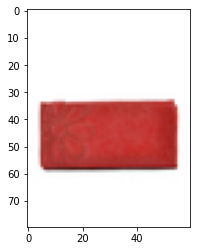

In [4]:
# Show an image of the dataset
image = cv2.imread("fashion-dataset-small/images/17082.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

#### Structure du dataset

Le dataset est composé de 10 caractéristiques (id, gender, masterCategory, subCategory, articleType, baseColour, season, year, usage, productDisplayName).

Afin d'effectuer la reconnaissance de vêtements, nous avons dû dans un premier temps sélectionner la caractéristique qu'on allait utiliser plus tard pour entrainer le modèle. Dans notre cas, nous avons choisi d'utiliser la caractéristique "subCategory" car elle disposait d'assez de classes avec au moins 500+ données labélisées par classe.

Ensuite, nous avons conservé que les classes qui correspondait à des vêtements / accessoires qui disposait de 500+ données labélisées, pour arriver à un total de 30848 données labélisées.

In [5]:
# Drop subCategory that is not Topwear, Bottomwear, Shoes, Sandal, Bags, Flip Flops, Dress
df = df[df.subCategory.isin(["Topwear", "Bottomwear", "Shoes", "Sandal", "Bags", "Flip Flops", "Dress"])]

# Show dataset size with Topwear, Bottomwear, Shoes, Sandals and Bags
display("Dataset size", df.shape[0])

'Dataset size'

30848

#### Instanciation du device

Afin d'obtenir de meilleur performance lors de l'entrainement et de l'évaluation des différents modèles, nous allons utiliser un GPU à l'aide de cuda

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device

print(device)

cuda:0


In [12]:
from torch.utils.data import Dataset

# Create a class for the dataset with colors pictures
class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = "fashion-dataset-small/images/" + str(self.df.iloc[idx, 0]) + ".jpg"
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 4]

        if self.transform:
            image = self.transform(image)

        return image, label

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = FashionDataset(df, transform=transform)

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for batch_id, batch in enumerate(train_loader):
    images, labels  = batch
    if batch_id == 0:
        print(images.shape)
        print(labels)
        break

torch.Size([64, 3, 64, 64])
('Tshirts', 'Heels', 'Sports Shoes', 'Tshirts', 'Tshirts', 'Tunics', 'Casual Shoes', 'Sweatshirts', 'Casual Shoes', 'Kurtas', 'Shorts', 'Tshirts', 'Sports Sandals', 'Handbags', 'Sandals', 'Heels', 'Heels', 'Shirts', 'Sports Shoes', 'Tshirts', 'Dresses', 'Track Pants', 'Kurtas', 'Shirts', 'Flip Flops', 'Trousers', 'Handbags', 'Tshirts', 'Tshirts', 'Sweatshirts', 'Tshirts', 'Kurtas', 'Sports Shoes', 'Kurtas', 'Trousers', 'Flats', 'Tshirts', 'Heels', 'Handbags', 'Flip Flops', 'Tshirts', 'Kurtas', 'Handbags', 'Sports Shoes', 'Shirts', 'Tshirts', 'Formal Shoes', 'Tshirts', 'Tshirts', 'Trousers', 'Tops', 'Sports Shoes', 'Tshirts', 'Jackets', 'Casual Shoes', 'Tops', 'Tshirts', 'Handbags', 'Kurtas', 'Sports Shoes', 'Sports Shoes', 'Casual Shoes', 'Casual Shoes', 'Tshirts')


In [ ]:
# Fonction entraînement

def train_optim(model, epochs, log_frequency, device, learning_rate=1e-4):

  AccuracyForEachIteration = []

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  for t in range(epochs):

      model.train() # we specify that we are training the model

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(trainloader) : 

        images, labels  = batch

        # we put the data on the same device
        images , labels = images.to(device), labels.to(device)  
        
        y_pred = model(images) # forward pass output=logits

        loss = loss_fn(y_pred, labels)

        if batch_id % log_frequency == 0:
            print("epoch: {:03d}, batch: {:03d}, loss: {:.3f} ".format(t+1, batch_id+1, loss.item()))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      # Model evaluation after each step computing the accuracy
      model.eval()
      total = 0
      correct = 0
      for batch_id, batch in enumerate(testloader):
        images , labels = batch
        images , labels = images.to(device), labels.to(device)
        y_pred = model(images) # forward computes the logits
        sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
        _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      AccuracyForEachIteration = np.append(AccuracyForEachIteration,(100 * correct / total))
      print("[validation] accuracy: {:.3f}%\n".format(100 * correct / total))

  plt.plot(np.arange(0,epochs),AccuracyForEachIteration,color='red')
  plt.xlabel('iteration')
  plt.ylabel('accuracy')
  plt.show()